In [33]:
# Only necessary if you're not sure whether the packages are already available
!pip install --quiet numpy pandas matplotlib scipy scikit-learn


In [34]:
# Install required packages
!pip install yfinance networkx matplotlib seaborn pandas numpy scipy scikit-learn

In [35]:
%%writefile correlation_measures.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

def pearson_correlation(x, y):
    """
    Calculate Pearson's correlation coefficient
    """
    return np.corrcoef(x, y)[0, 1]

def spearman_correlation(x, y):
    """
    Calculate Spearman's rank correlation coefficient
    """
    return stats.spearmanr(x, y)[0]

def kendall_correlation(x, y):
    """
    Calculate Kendall's tau correlation coefficient
    """
    return stats.kendalltau(x, y)[0]

def distance_correlation(x, y):
    """
    Calculate the distance correlation between two 1-dimensional arrays

    Distance correlation is a measure of dependence between random variables,
    which is zero if and only if the variables are independent.

    Reference: https://en.wikipedia.org/wiki/Distance_correlation
    """
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)

    if x.ndim > 1 or y.ndim > 1:
        raise ValueError("Input arrays must be 1-dimensional")

    n = x.size
    if n != y.size:
        raise ValueError("Input arrays must have the same length")

    # Center the distance matrices
    x_dist = squareform(pdist(x[:, np.newaxis]))
    y_dist = squareform(pdist(y[:, np.newaxis]))

    # Double centering
    x_centered = x_dist - x_dist.mean(axis=0) - x_dist.mean(axis=1)[:, np.newaxis] + x_dist.mean()
    y_centered = y_dist - y_dist.mean(axis=0) - y_dist.mean(axis=1)[:, np.newaxis] + y_dist.mean()

    # Calculate the distance covariance
    dcov_xy = np.sqrt(np.mean(x_centered * y_centered))
    dcov_xx = np.sqrt(np.mean(x_centered * x_centered))
    dcov_yy = np.sqrt(np.mean(y_centered * y_centered))

    # Handle small values due to numerical precision
    if dcov_xx * dcov_yy < 1e-15:
        return 0
    else:
        return dcov_xy / np.sqrt(dcov_xx * dcov_yy)

def binary_expansion_test(x, y, max_order=5):
    """
    Implement a simplified version of Binary Expansion Testing (BET)

    This is a computationally efficient method for testing non-linear dependence
    by examining different bit levels of binary representations of the data.

    Parameters:
    -----------
    x, y : numpy arrays
        Input data arrays
    max_order : int
        Maximum order of binary expansion to consider

    Returns:
    --------
    bet_score : float
        A measure of dependence between x and y
    """
    # Normalize data to [0, 1] range
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) > np.min(x) else np.zeros_like(x)
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y)) if np.max(y) > np.min(y) else np.zeros_like(y)

    # Initialize BET score
    bet_score = 0

    # Calculate dependence at different binary expansion levels
    for i in range(1, max_order + 1):
        # Generate binary expansions
        x_bits = (x_norm * (2**i)).astype(int) % 2
        y_bits = (y_norm * (2**i)).astype(int) % 2

        # Contingency table
        contingency = np.zeros((2, 2))
        for x_bit, y_bit in zip(x_bits, y_bits):
            contingency[x_bit, y_bit] += 1

        # Calculate chi-square statistic
        chi2, _, _, _ = stats.chi2_contingency(contingency, correction=False)

        # Weight by 2^-i (higher significance for earlier bits)
        bet_score += chi2 * (2**-i)

    # Normalize by sample size
    bet_score /= len(x)

    return bet_score

def mutual_information(x, y, n_neighbors=3):
    """
    Estimate the mutual information between two continuous variables
    using a k-nearest neighbors approach

    Parameters:
    -----------
    x, y : numpy arrays
        Input data arrays
    n_neighbors : int
        Number of neighbors to consider

    Returns:
    --------
    mi : float
        Estimated mutual information
    """
    x = x.reshape(-1, 1) if x.ndim == 1 else x
    y = y.reshape(-1, 1) if y.ndim == 1 else y

    n_samples = x.shape[0]

    # Joint space
    xy = np.hstack([x, y])

    # Find nearest neighbors in joint space
    knn_xy = NearestNeighbors(n_neighbors=n_neighbors + 1)  # +1 because point itself is included
    knn_xy.fit(xy)
    dxy, _ = knn_xy.kneighbors(xy)
    dxy = dxy[:, -1]  # Get distance to k-th neighbor

    # Find nearest neighbors in x space
    knn_x = NearestNeighbors(n_neighbors=n_neighbors + 1)
    knn_x.fit(x)
    dx, _ = knn_x.kneighbors(x)
    dx = dx[:, -1]

    # Find nearest neighbors in y space
    knn_y = NearestNeighbors(n_neighbors=n_neighbors + 1)
    knn_y.fit(y)
    dy, _ = knn_y.kneighbors(y)
    dy = dy[:, -1]

    # Calculate mutual information
    # MI = digamma(k) + digamma(N) - mean(digamma(nx) + digamma(ny))
    mi = (np.mean(np.log(dx) + np.log(dy) - np.log(dxy)) +
          np.log(n_samples))

    return max(0, mi)  # Ensure non-negative

def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two distributions

    To avoid numerical issues, we add a small epsilon to the distributions
    """
    epsilon = 1e-10
    p = np.asarray(p) + epsilon
    q = np.asarray(q) + epsilon

    # Normalize to ensure they are proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    return np.sum(p * np.log(p / q))

def jensen_shannon_divergence(p, q):
    """
    Calculate the Jensen-Shannon divergence between two distributions
    """
    p = np.asarray(p)
    q = np.asarray(q)

    # Normalize to ensure they are proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)

    m = 0.5 * (p + q)

    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def estimate_joint_distribution(x, y, bins=10):
    """
    Estimate the joint and marginal distributions of x and y
    using histogram binning
    """
    # Create histogram bins
    x_bins = np.linspace(np.min(x), np.max(x), bins + 1)
    y_bins = np.linspace(np.min(y), np.max(y), bins + 1)

    # Calculate joint histogram
    joint_hist, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins], density=True)

    # Calculate marginal histograms
    x_hist, _ = np.histogram(x, bins=x_bins, density=True)
    y_hist, _ = np.histogram(y, bins=y_bins, density=True)

    # Create product distribution (independent case)
    prod_hist = np.outer(x_hist, y_hist)

    # Ensure proper normalization
    joint_hist /= np.sum(joint_hist)
    prod_hist /= np.sum(prod_hist)

    return joint_hist, prod_hist, x_hist, y_hist

def distribution_divergence(x, y, bins=10, method='kl'):
    """
    Measure divergence between joint distribution and product
    of marginal distributions.

    This quantifies the departure from independence.
    """
    joint_hist, prod_hist, _, _ = estimate_joint_distribution(x, y, bins)

    if method == 'kl':
        return kl_divergence(joint_hist.flatten(), prod_hist.flatten())
    elif method == 'js':
        return jensen_shannon_divergence(joint_hist.flatten(), prod_hist.flatten())
    else:
        raise ValueError("Method must be 'kl' or 'js'")

def generate_data(type_name, n_samples=1000, noise_level=0.1):
    """
    Generate synthetic data with various types of dependencies

    Parameters:
    -----------
    type_name : str
        Type of relationship to generate:
        'linear', 'quadratic', 'cubic', 'sine', 'circle',
        'step', 'independent'
    n_samples : int
        Number of samples to generate
    noise_level : float
        Level of noise to add

    Returns:
    --------
    x, y : numpy arrays
        Generated data
    """
    # Generate independent x values
    x = np.random.uniform(-1, 1, n_samples)

    # Generate y based on the relationship type
    if type_name == 'linear':
        y = x + noise_level * np.random.normal(0, 1, n_samples)

    elif type_name == 'quadratic':
        y = x**2 + noise_level * np.random.normal(0, 1, n_samples)

    elif type_name == 'cubic':
        y = x**3 + noise_level * np.random.normal(0, 1, n_samples)

    elif type_name == 'sine':
        y = np.sin(5 * x) + noise_level * np.random.normal(0, 1, n_samples)

    elif type_name == 'circle':
        theta = np.random.uniform(0, 2*np.pi, n_samples)
        radius = 1 + noise_level * np.random.normal(0, 0.1, n_samples)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)

    elif type_name == 'step':
        y = np.zeros(n_samples)
        y[x > 0] = 1
        y += noise_level * np.random.normal(0, 1, n_samples)

    elif type_name == 'independent':
        y = np.random.uniform(-1, 1, n_samples)

    else:
        raise ValueError(f"Unknown relationship type: {type_name}")

    return x, y

def plot_relationship(x, y, title):
    """
    Plot the relationship between x and y
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(alpha=0.3)
    return plt.gcf()

def evaluate_all_measures(x, y):
    """
    Evaluate all correlation measures for a given dataset
    """
    start_time = time.time()
    pearson = pearson_correlation(x, y)
    pearson_time = time.time() - start_time

    start_time = time.time()
    spearman = spearman_correlation(x, y)
    spearman_time = time.time() - start_time

    start_time = time.time()
    kendall = kendall_correlation(x, y)
    kendall_time = time.time() - start_time

    start_time = time.time()
    dcorr = distance_correlation(x, y)
    dcorr_time = time.time() - start_time

    start_time = time.time()
    bet = binary_expansion_test(x, y)
    bet_time = time.time() - start_time

    start_time = time.time()
    mi = mutual_information(x, y)
    mi_time = time.time() - start_time

    start_time = time.time()
    kl_div = distribution_divergence(x, y, method='kl')
    kl_time = time.time() - start_time

    start_time = time.time()
    js_div = distribution_divergence(x, y, method='js')
    js_time = time.time() - start_time

    results = {
        'Pearson': (pearson, pearson_time),
        'Spearman': (spearman, spearman_time),
        'Kendall': (kendall, kendall_time),
        'Distance Correlation': (dcorr, dcorr_time),
        'BET': (bet, bet_time),
        'Mutual Information': (mi, mi_time),
        'KL Divergence': (kl_div, kl_time),
        'JS Divergence': (js_div, js_time)
    }

    return results

def generate_and_evaluate_all(n_samples=1000, noise_level=0.1):
    """
    Generate all types of relationships and evaluate all measures
    """
    relationship_types = [
        'linear', 'quadratic', 'cubic', 'sine',
        'circle', 'step', 'independent'
    ]

    all_results = {}
    plots = {}

    for rel_type in relationship_types:
        x, y = generate_data(rel_type, n_samples, noise_level)
        results = evaluate_all_measures(x, y)
        all_results[rel_type] = results

        plots[rel_type] = plot_relationship(x, y, f"{rel_type.capitalize()} Relationship")

    return all_results, plots

def composite_measure(x, y, weights=None):
    """
    Create a composite correlation measure that combines multiple measures

    Parameters:
    -----------
    x, y : numpy arrays
        Input data arrays
    weights : dict
        Dictionary with weights for each measure.
        If None, equal weights are used.

    Returns:
    --------
    score : float
        Composite correlation score
    """
    # Default weights if none provided
    if weights is None:
        weights = {
            'Distance Correlation': 0.3,
            'Mutual Information': 0.3,
            'BET': 0.2,
            'JS Divergence': 0.2
        }

    # Calculate each measure
    measures = {
        'Distance Correlation': distance_correlation(x, y),
        'Mutual Information': mutual_information(x, y),
        'BET': binary_expansion_test(x, y),
        'JS Divergence': distribution_divergence(x, y, method='js')
    }

    # Normalize JS Divergence to [0,1] range (assuming max value of 1)
    measures['JS Divergence'] = min(measures['JS Divergence'], 1.0)

    # Calculate weighted sum
    score = sum(weight * measures[measure] for measure, weight in weights.items())

    # Normalize to [0,1]
    total_weight = sum(weights.values())
    if total_weight > 0:
        score /= total_weight

    return score

# Generate and evaluate example data
if __name__ == "__main__":
    # Example usage
    x, y = generate_data('quadratic', n_samples=500, noise_level=0.2)
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.6)
    plt.title("Quadratic Relationship Example")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(alpha=0.3)
    plt.show()

    # Evaluate all measures
    results = evaluate_all_measures(x, y)
    for measure, (value, time_taken) in results.items():
        print(f"{measure}: {value:.4f} (Time: {time_taken:.4f} seconds)")

Overwriting correlation_measures.py


In [36]:
%%writefile correlation_comparison.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import time
import warnings
warnings.filterwarnings('ignore')

# Import functions from the previous module
# In Colab, you'll need to ensure this file is imported or the functions are defined
from correlation_measures import (
    generate_data, evaluate_all_measures, composite_measure,
    pearson_correlation, spearman_correlation, kendall_correlation,
    distance_correlation, binary_expansion_test, mutual_information,
    distribution_divergence
)

# Create a figure to show all relationship types
def plot_all_relationships(noise_level=0.1, n_samples=1000):
    """
    Generate and plot all types of relationships
    """
    relationship_types = [
        'linear', 'quadratic', 'cubic', 'sine',
        'circle', 'step', 'independent'
    ]

    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig)

    for i, rel_type in enumerate(relationship_types):
        row, col = divmod(i, 3)
        ax = fig.add_subplot(gs[row, col])

        x, y = generate_data(rel_type, n_samples, noise_level)
        ax.scatter(x, y, alpha=0.6)
        ax.set_title(f"{rel_type.capitalize()} Relationship")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    return fig

# Compare all measures on all relationship types
def compare_all_measures(noise_level=0.1, n_samples=1000):
    """
    Compare all correlation measures on all relationship types
    """
    relationship_types = [
        'linear', 'quadratic', 'cubic', 'sine',
        'circle', 'step', 'independent'
    ]

    # Initialize results dictionary
    results_dict = {
        'Relationship': [],
        'Measure': [],
        'Value': [],
        'Time (s)': []
    }

    for rel_type in relationship_types:
        x, y = generate_data(rel_type, n_samples, noise_level)
        results = evaluate_all_measures(x, y)

        # Add composite measure
        start_time = time.time()
        comp_value = composite_measure(x, y)
        comp_time = time.time() - start_time
        results['Composite'] = (comp_value, comp_time)

        for measure, (value, time_taken) in results.items():
            results_dict['Relationship'].append(rel_type.capitalize())
            results_dict['Measure'].append(measure)
            results_dict['Value'].append(value)
            results_dict['Time (s)'].append(time_taken)

    # Convert to DataFrame
    results_df = pd.DataFrame(results_dict)

    return results_df

# Plot heatmap of results
def plot_results_heatmap(results_df):
    """
    Create a heatmap visualization of correlation measure results
    """
    # Pivot the dataframe
    pivot_df = results_df.pivot(index='Relationship', columns='Measure', values='Value')

    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'Correlation Value'})
    plt.title('Comparison of Correlation Measures Across Different Relationships', fontsize=14)
    plt.tight_layout()
    return plt.gcf()

# Plot time comparison
def plot_time_comparison(results_df):
    """
    Plot the computational time for each measure
    """
    # Calculate average time per measure
    time_df = results_df.groupby('Measure')['Time (s)'].mean().reset_index()
    time_df = time_df.sort_values('Time (s)')

    plt.figure(figsize=(12, 6))
    bars = plt.barh(time_df['Measure'], time_df['Time (s)'], color='skyblue')
    plt.xscale('log')
    plt.xlabel('Average Computation Time (seconds, log scale)')
    plt.title('Computational Efficiency of Different Correlation Measures')
    plt.grid(alpha=0.3, axis='x')

    # Add time values as text
    for bar in bars:
        width = bar.get_width()
        plt.text(width * 1.1, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}s',
                 va='center')

    plt.tight_layout()
    return plt.gcf()

# Compare measures with varying noise levels
def compare_noise_sensitivity(relationship_type='quadratic', n_samples=1000):
    """
    Compare how different measures perform with increasing noise levels
    """
    noise_levels = np.linspace(0, 0.5, 11)  # 0 to 0.5 noise
    measures = ['Pearson', 'Spearman', 'Distance Correlation', 'BET',
                'Mutual Information', 'JS Divergence', 'Composite']

    # Initialize results
    noise_results = {measure: [] for measure in measures}

    for noise in noise_levels:
        x, y = generate_data(relationship_type, n_samples, noise)

        # Calculate all measures
        results = evaluate_all_measures(x, y)

        # Add composite measure
        results['Composite'] = (composite_measure(x, y), 0)

        # Store values
        for measure in measures:
            noise_results[measure].append(results[measure][0])

    # Plot results
    plt.figure(figsize=(12, 7))
    for measure in measures:
        plt.plot(noise_levels, noise_results[measure], label=measure, marker='o', linewidth=2)

    plt.xlabel('Noise Level')
    plt.ylabel('Correlation Value')
    plt.title(f'Noise Sensitivity for {relationship_type.capitalize()} Relationship')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

# Visualize joint vs. product distributions
def visualize_distributions(relationship_type='quadratic', n_samples=1000, noise_level=0.1, bins=10):
    """
    Visualize the joint distribution and the product of marginals
    to illustrate the concept of distribution divergence
    """
    x, y = generate_data(relationship_type, n_samples, noise_level)

    # Calculate distributions
    from correlation_measures import estimate_joint_distribution
    joint_hist, prod_hist, x_hist, y_hist = estimate_joint_distribution(x, y, bins)

    # Create bin centers for x and y
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    x_bins = np.linspace(x_min, x_max, bins + 1)
    y_bins = np.linspace(y_min, y_max, bins + 1)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2
    y_centers = (y_bins[:-1] + y_bins[1:]) / 2

    # Create figure
    fig = plt.figure(figsize=(16, 6))

    # Plot the data
    ax1 = fig.add_subplot(131)
    ax1.scatter(x, y, alpha=0.5)
    ax1.set_title(f"{relationship_type.capitalize()} Relationship")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.grid(alpha=0.3)

    # Plot joint distribution
    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(joint_hist.T, origin='lower', aspect='auto',
                    extent=[x_min, x_max, y_min, y_max])
    ax2.set_title("Joint Distribution")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    plt.colorbar(im2, ax=ax2, label='Density')

    # Plot product of marginals
    ax3 = fig.add_subplot(133)
    im3 = ax3.imshow(prod_hist.T, origin='lower', aspect='auto',
                    extent=[x_min, x_max, y_min, y_max])
    ax3.set_title("Product of Marginals")
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im3, ax=ax3, label='Density')

    plt.tight_layout()

    # Calculate divergence measures
    kl = distribution_divergence(x, y, bins, method='kl')
    js = distribution_divergence(x, y, bins, method='js')

    plt.suptitle(f"KL Divergence: {kl:.4f}, JS Divergence: {js:.4f}", fontsize=14, y=1.05)

    return fig

# Evaluate our proposed composite measure vs. standard measures
def evaluate_composite_measure(n_trials=100, n_samples=500):
    """
    Compare the performance of our composite measure against standard measures
    across multiple trials with different relationship types
    """
    relationship_types = [
        'linear', 'quadratic', 'cubic', 'sine',
        'circle', 'step', 'independent'
    ]

    # For each relationship type, we'll calculate how often each measure
    # correctly ranks that relationship as more dependent than independent data
    correct_rankings = {rel: {
        'Pearson': 0,
        'Spearman': 0,
        'Distance Correlation': 0,
        'BET': 0,
        'Mutual Information': 0,
        'JS Divergence': 0,
        'Composite': 0
    } for rel in relationship_types if rel != 'independent'}

    for _ in range(n_trials):
        # Generate independent data as baseline
        indep_x, indep_y = generate_data('independent', n_samples)
        indep_results = evaluate_all_measures(indep_x, indep_y)
        indep_composite = composite_measure(indep_x, indep_y)

        # For each relationship type
        for rel in relationship_types:
            if rel == 'independent':
                continue

            # Generate data with this relationship
            rel_x, rel_y = generate_data(rel, n_samples)
            rel_results = evaluate_all_measures(rel_x, rel_y)
            rel_composite = composite_measure(rel_x, rel_y)

            # Check if each measure correctly ranks this as more dependent
            for measure in correct_rankings[rel].keys():
                if measure == 'Composite':
                    if rel_composite > indep_composite:
                        correct_rankings[rel][measure] += 1
                else:
                    if rel_results[measure][0] > indep_results[measure][0]:
                        correct_rankings[rel][measure] += 1

    # Convert to percentages
    for rel in correct_rankings:
        for measure in correct_rankings[rel]:
            correct_rankings[rel][measure] = (correct_rankings[rel][measure] / n_trials) * 100

    # Convert to DataFrame for plotting
    df_list = []
    for rel in correct_rankings:
        for measure, value in correct_rankings[rel].items():
            df_list.append({
                'Relationship': rel.capitalize(),
                'Measure': measure,
                'Correct Ranking (%)': value
            })

    ranking_df = pd.DataFrame(df_list)

    # Plot the results
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Relationship', y='Correct Ranking (%)',
                hue='Measure', data=ranking_df)
    plt.title('Percentage of Trials Where Measure Correctly Identifies Dependence', fontsize=14)
    plt.legend(title='Measure', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 100)
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()

    return plt.gcf(), ranking_df

# Run all analyses and visualizations
def run_full_analysis(n_samples=1000, noise_level=0.1):
    """
    Run all analyses and return results
    """
    results = {}

    # Generate plots for all relationship types
    results['relationships_plot'] = plot_all_relationships(noise_level, n_samples)

    # Compare all measures on all relationship types
    results['comparison_df'] = compare_all_measures(noise_level, n_samples)

    # Plot heatmap of results
    results['heatmap'] = plot_results_heatmap(results['comparison_df'])

    # Plot time comparison
    results['time_plot'] = plot_time_comparison(results['comparison_df'])

    # Compare noise sensitivity
    results['noise_sensitivity'] = compare_noise_sensitivity(relationship_type='quadratic', n_samples=n_samples)

    # Visualize distributions
    results['distribution_vis'] = visualize_distributions(relationship_type='quadratic', n_samples=n_samples, noise_level=noise_level)

    # Evaluate composite measure
    results['composite_evaluation'], results['ranking_df'] = evaluate_composite_measure(n_trials=50, n_samples=n_samples)

    return results

# ---------------
# Main execution code for Colab
# ---------------

if __name__ == "__main__":
    # Set the parameters
    n_samples = 1000
    noise_level = 0.1

    # Run the full analysis
    results = run_full_analysis(n_samples, noise_level)

    # Display all plots
    plt.show()

    # Print a summary of the results
    comparison_df = results['comparison_df']

    # Calculate the average value for each measure
    avg_values = comparison_df.groupby('Measure')['Value'].mean().sort_values(ascending=False)
    print("\nAverage correlation value across all relationships:")
    for measure, avg in avg_values.items():
        print(f"{measure}: {avg:.4f}")

    # Calculate the average time for each measure
    avg_times = comparison_df.groupby('Measure')['Time (s)'].mean().sort_values()
    print("\nAverage computation time across all relationships:")
    for measure, avg in avg_times.items():
        print(f"{measure}: {avg:.4f} seconds")

    # Print composite measure evaluation summary
    ranking_df = results['ranking_df']
    avg_rankings = ranking_df.groupby('Measure')['Correct Ranking (%)'].mean().sort_values(ascending=False)
    print("\nAverage correct ranking percentage across all relationships:")
    for measure, avg in avg_rankings.items():
        print(f"{measure}: {avg:.2f}%")

Overwriting correlation_comparison.py


In [37]:
%%writefile financial_application.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import networkx as nx
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import correlation measures
from correlation_measures import (
    pearson_correlation, spearman_correlation, distance_correlation,
    binary_expansion_test, mutual_information, distribution_divergence,
    composite_measure
)

def download_stock_data(tickers, start_date, end_date):
    """
    Download historical stock data for the given tickers
    """
    data = yf.download(tickers, start=start_date, end=end_date)

    # Handle different column structures
    if isinstance(data.columns, pd.MultiIndex):
        # MultiIndex structure
        if 'Adj Close' in data.columns.levels[0]:
            close_prices = data['Adj Close']
        else:
            close_prices = data['Close']
    else:
        # Regular DataFrame
        if 'Adj Close' in data.columns:
            close_prices = data['Adj Close']
        else:
            close_prices = data['Close']

    return close_prices

def calculate_returns(prices, period='daily'):
    """
    Calculate returns from price data
    """
    if period == 'daily':
        returns = prices.pct_change().dropna()
    elif period == 'weekly':
        returns = prices.pct_change(5).dropna()
    elif period == 'monthly':
        returns = prices.pct_change(21).dropna()
    else:
        raise ValueError("Period must be 'daily', 'weekly', or 'monthly'")

    return returns

def build_correlation_matrix(returns, method='pearson'):
    """
    Build a correlation matrix using the specified method
    """
    n = len(returns.columns)
    corr_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            x = returns.iloc[:, i].values
            y = returns.iloc[:, j].values

            # Calculate correlation using the specified method
            if method == 'pearson':
                corr = pearson_correlation(x, y)
            elif method == 'spearman':
                corr = spearman_correlation(x, y)
            elif method == 'distance':
                corr = distance_correlation(x, y)
            elif method == 'bet':
                corr = binary_expansion_test(x, y)
            elif method == 'mutual_info':
                corr = mutual_information(x, y)
            elif method == 'js_divergence':
                corr = distribution_divergence(x, y, method='js')
            elif method == 'composite':
                corr = composite_measure(x, y)
            else:
                raise ValueError(f"Unknown method: {method}")

            # Fill both the upper and lower triangles
            corr_matrix[i, j] = corr
            if i != j:  # Don't double-count the diagonal
                corr_matrix[j, i] = corr

    return pd.DataFrame(
        corr_matrix,
        index=returns.columns,
        columns=returns.columns
    )

def plot_correlation_heatmap(corr_matrix, title):
    """
    Plot a heatmap of the correlation matrix
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f',
                linewidths=.5, cbar_kws={'label': 'Correlation'})
    plt.title(title, fontsize=16)
    plt.tight_layout()
    return plt.gcf()

def compare_correlation_methods(returns):
    """
    Compare different correlation methods on the returns data
    """
    methods = [
        'pearson', 'spearman', 'distance',
        'bet', 'mutual_info', 'js_divergence', 'composite'
    ]

    method_names = {
        'pearson': 'Pearson',
        'spearman': 'Spearman',
        'distance': 'Distance Correlation',
        'bet': 'Binary Expansion Test',
        'mutual_info': 'Mutual Information',
        'js_divergence': 'JS Divergence',
        'composite': 'Composite Measure'
    }

    # Calculate correlation matrices for all methods
    corr_matrices = {}
    for method in methods:
        corr_matrices[method] = build_correlation_matrix(returns, method)

    # Create a plot with all heatmaps
    fig, axes = plt.subplots(3, 3, figsize=(18, 16))
    axes = axes.flatten()

    for i, method in enumerate(methods):
        if i >= len(axes):
            break

        sns.heatmap(corr_matrices[method], annot=True, cmap='viridis',
                    fmt='.2f', linewidths=.5, ax=axes[i],
                    cbar_kws={'label': 'Correlation'})
        axes[i].set_title(f"{method_names[method]} Correlation", fontsize=14)

    # Hide any unused subplots
    for i in range(len(methods), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle("Comparison of Correlation Methods on Financial Returns", fontsize=18)

    return fig, corr_matrices

def build_network_graph(corr_matrix, threshold=0.3):
    """
    Build a network graph from the correlation matrix
    """
    # Create a copy of the correlation matrix
    cm = corr_matrix.copy()

    # Set values below threshold to 0
    cm[cm < threshold] = 0

    # Create a graph from the matrix
    G = nx.from_pandas_adjacency(cm)

    # Calculate network metrics
    metrics = {
        'density': nx.density(G),
        'average_clustering': nx.average_clustering(G),
        'average_path_length': 'N/A'  # Will calculate only if connected
    }

    # Check if the graph is connected before calculating average path length
    if nx.is_connected(G):
        metrics['average_path_length'] = nx.average_shortest_path_length(G)

    return G, metrics

def plot_network_graph(G, title):
    """
    Plot the network graph
    """
    plt.figure(figsize=(12, 10))

    # Calculate edge weights for visualization
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

    # Calculate node sizes based on degree centrality
    centrality = nx.degree_centrality(G)
    node_sizes = [centrality[node] * 5000 + 100 for node in G.nodes()]

    # Use spring layout for node positioning
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    nx.draw_networkx(
        G, pos=pos,
        node_size=node_sizes,
        width=edge_weights,
        edge_color='gray',
        node_color='skyblue',
        alpha=0.8,
        with_labels=True,
        font_weight='bold'
    )

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    return plt.gcf()

def compare_network_graphs(corr_matrices, threshold=0.3):
    """
    Compare network graphs from different correlation methods
    """
    methods = list(corr_matrices.keys())

    method_names = {
        'pearson': 'Pearson',
        'spearman': 'Spearman',
        'distance': 'Distance Correlation',
        'bet': 'Binary Expansion Test',
        'mutual_info': 'Mutual Information',
        'js_divergence': 'JS Divergence',
        'composite': 'Composite Measure'
    }

    # Create graphs for all methods
    graphs = {}
    metrics = {}
    for method in methods:
        graphs[method], metrics[method] = build_network_graph(
            corr_matrices[method], threshold
        )

    # Create a plot with all graphs
    fig, axes = plt.subplots(3, 3, figsize=(18, 16))
    axes = axes.flatten()

    for i, method in enumerate(methods):
        if i >= len(axes):
            break

        # Draw the graph in the current subplot
        ax = axes[i]
        G = graphs[method]

        # Calculate edge weights and node sizes
        edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
        centrality = nx.degree_centrality(G)
        node_sizes = [centrality[node] * 5000 + 100 for node in G.nodes()]

        # Use spring layout
        pos = nx.spring_layout(G, seed=42)

        # Draw the graph
        nx.draw_networkx(
            G, pos=pos, ax=ax,
            node_size=node_sizes,
            width=edge_weights,
            edge_color='gray',
            node_color='skyblue',
            alpha=0.8,
            with_labels=True,
            font_weight='bold',
            font_size=8
        )

        ax.set_title(f"{method_names[method]}", fontsize=14)
        ax.axis('off')

    # Hide any unused subplots
    for i in range(len(methods), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f"Network Graphs (Threshold: {threshold})", fontsize=18)

    # Compare network metrics
    metrics_df = pd.DataFrame(metrics).T

    return fig, metrics_df

def rolling_window_analysis(returns, window_size=60, step=20, method='composite'):
    """
    Perform rolling window analysis to detect changes in correlation structure
    """
    n_windows = (len(returns) - window_size) // step + 1
    tickers = returns.columns
    n_tickers = len(tickers)

    # Initialize arrays to store results
    dates = []
    avg_correlations = []
    max_correlations = []
    network_metrics = []

    for i in range(n_windows):
        # Get data for the current window
        start_idx = i * step
        end_idx = start_idx + window_size
        window_data = returns.iloc[start_idx:end_idx]

        # Store the end date of the window
        dates.append(window_data.index[-1])

        # Calculate correlation matrix
        corr_matrix = build_correlation_matrix(window_data, method)

        # Calculate average and maximum correlation (excluding self-correlations)
        mask = ~np.eye(n_tickers, dtype=bool)
        avg_corr = corr_matrix.values[mask].mean()
        max_corr = corr_matrix.values[mask].max()

        avg_correlations.append(avg_corr)
        max_correlations.append(max_corr)

        # Build network and calculate metrics
        G, metrics = build_network_graph(corr_matrix, threshold=0.3)
        network_metrics.append(metrics)

    # Create DataFrame for results
    results = pd.DataFrame({
        'Date': dates,
        'Avg_Correlation': avg_correlations,
        'Max_Correlation': max_correlations
    })

    # Add network metrics
    for metric in network_metrics[0].keys():
        results[metric] = [m.get(metric, np.nan) for m in network_metrics]

    # Plot results
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

    # Plot average and maximum correlation
    axes[0].plot(results['Date'], results['Avg_Correlation'],
                label='Average Correlation', marker='o')
    axes[0].plot(results['Date'], results['Max_Correlation'],
                label='Maximum Correlation', marker='s')
    axes[0].set_title(f'Rolling Window Analysis ({method.capitalize()} Method)', fontsize=16)
    axes[0].set_ylabel('Correlation')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot network density
    axes[1].plot(results['Date'], results['density'], marker='o', color='green')
    axes[1].set_title('Network Density Over Time', fontsize=14)
    axes[1].set_ylabel('Density')
    axes[1].grid(alpha=0.3)

    # Plot average clustering coefficient
    axes[2].plot(results['Date'], results['average_clustering'], marker='o', color='purple')
    axes[2].set_title('Average Clustering Coefficient Over Time', fontsize=14)
    axes[2].set_ylabel('Avg. Clustering')
    axes[2].set_xlabel('Date')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()

    return fig, results

def detect_market_regimes(returns, method='composite', n_clusters=3):
    """
    Detect market regimes using correlation matrices and clustering
    """
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    # Parameters for rolling windows
    window_size = 60  # ~3 months of trading days
    step = 20  # ~1 month of trading days

    # Initialize lists to store data
    dates = []
    correlation_matrices = []
    avg_correlations = []
    volatilities = []

    # Perform rolling window analysis
    n_windows = (len(returns) - window_size) // step + 1

    for i in range(n_windows):
        # Get data for the current window
        start_idx = i * step
        end_idx = start_idx + window_size
        window_data = returns.iloc[start_idx:end_idx]

        # Store the end date of the window
        dates.append(window_data.index[-1])

        # Calculate correlation matrix
        corr_matrix = build_correlation_matrix(window_data, method)
        correlation_matrices.append(corr_matrix)

        # Calculate average correlation (excluding self-correlations)
        mask = ~np.eye(len(corr_matrix), dtype=bool)
        avg_corr = corr_matrix.values[mask].mean()
        avg_correlations.append(avg_corr)

        # Calculate volatility (standard deviation of returns)
        volatility = window_data.std().mean()
        volatilities.append(volatility)

    # Create feature matrix for clustering
    features = np.column_stack([avg_correlations, volatilities])

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)

    # Create DataFrame with results
    results = pd.DataFrame({
        'Date': dates,
        'Avg_Correlation': avg_correlations,
        'Volatility': volatilities,
        'Cluster': clusters
    })

    # Find cluster centers in original feature space
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Plot results
    fig, axes = plt.subplots(2, 1, figsize=(14, 14))

    # Plot average correlation and volatility
    axes[0].plot(results['Date'], results['Avg_Correlation'],
                label='Average Correlation', color='blue')
    axes[0].set_ylabel('Correlation', color='blue')
    axes[0].tick_params(axis='y', labelcolor='blue')

    ax_twin = axes[0].twinx()
    ax_twin.plot(results['Date'], results['Volatility'],
                label='Volatility', color='red')
    ax_twin.set_ylabel('Volatility', color='red')
    ax_twin.tick_params(axis='y', labelcolor='red')

    axes[0].set_title(f'Market Indicators Over Time ({method.capitalize()} Method)', fontsize=16)
    axes[0].grid(alpha=0.3)

    # Add lines to show the regime changes
    for date, cluster in zip(results['Date'], results['Cluster']):
        axes[0].axvline(date, color='gray', alpha=0.2)

    # Add a legend
    lines1, labels1 = axes[0].get_legend_handles_labels()
    lines2, labels2 = ax_twin.get_legend_handles_labels()
    axes[0].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Plot clusters
    scatter = axes[1].scatter(
        results['Avg_Correlation'],
        results['Volatility'],
        c=results['Cluster'],
        cmap='viridis',
        alpha=0.7,
        edgecolors='k',
        s=100
    )

    # Plot cluster centers
    axes[1].scatter(
        cluster_centers[:, 0],
        cluster_centers[:, 1],
        c=range(n_clusters),
        cmap='viridis',
        marker='X',
        s=200,
        edgecolors='k'
    )

    axes[1].set_title('Market Regimes Clustering', fontsize=16)
    axes[1].set_xlabel('Average Correlation')
    axes[1].set_ylabel('Volatility')
    axes[1].grid(alpha=0.3)

    # Add a legend for clusters
    legend1 = axes[1].legend(*scatter.legend_elements(),
                            title="Clusters", loc="upper right")
    axes[1].add_artist(legend1)

    plt.tight_layout()

    return fig, results, correlation_matrices

# ---------------
# Main execution code for Colab
# ---------------

def main():
    # Define the stock tickers to analyze
    # Using major tech stocks and ETFs
    tickers = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META',
        'TSLA', 'NVDA', 'SPY', 'QQQ', 'XLK'
    ]

    # Define the time period
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*2)  # 2 years of data

    print(f"Downloading stock data for {len(tickers)} tickers from {start_date.date()} to {end_date.date()}...")

    # Download the data
    prices = download_stock_data(tickers, start_date, end_date)

    # Calculate returns
    returns = calculate_returns(prices, period='daily')

    print(f"Analyzing {len(returns)} days of returns data...")

    # Compare correlation methods
    print("Comparing correlation methods...")
    corr_fig, corr_matrices = compare_correlation_methods(returns)

    # Compare network graphs
    print("Building and comparing network graphs...")
    net_fig, metrics_df = compare_network_graphs(corr_matrices, threshold=0.3)

    # Perform rolling window analysis
    print("Performing rolling window analysis...")
    roll_fig, roll_results = rolling_window_analysis(returns, window_size=60, step=20, method='composite')

    # Detect market regimes
    print("Detecting market regimes...")
    regime_fig, regime_results, regime_corrs = detect_market_regimes(returns, method='composite', n_clusters=3)

    # Display results
    corr_fig.tight_layout()
    net_fig.tight_layout()
    roll_fig.tight_layout()
    regime_fig.tight_layout()

    print("\nNetwork metrics summary:")
    print(metrics_df)

    print("\nDetected market regimes:")
    regime_summary = regime_results.groupby('Cluster').agg({
        'Avg_Correlation': 'mean',
        'Volatility': 'mean',
        'Date': 'count'
    }).rename(columns={'Date': 'Number of periods'})
    print(regime_summary)

    return {
        'prices': prices,
        'returns': returns,
        'correlation_matrices': corr_matrices,
        'network_metrics': metrics_df,
        'rolling_results': roll_results,
        'regime_results': regime_results,
        'figures': {
            'correlation_comparison': corr_fig,
            'network_comparison': net_fig,
            'rolling_analysis': roll_fig,
            'regime_detection': regime_fig
        }
    }

if __name__ == "__main__":
    results = main()
    plt.show()

Overwriting financial_application.py


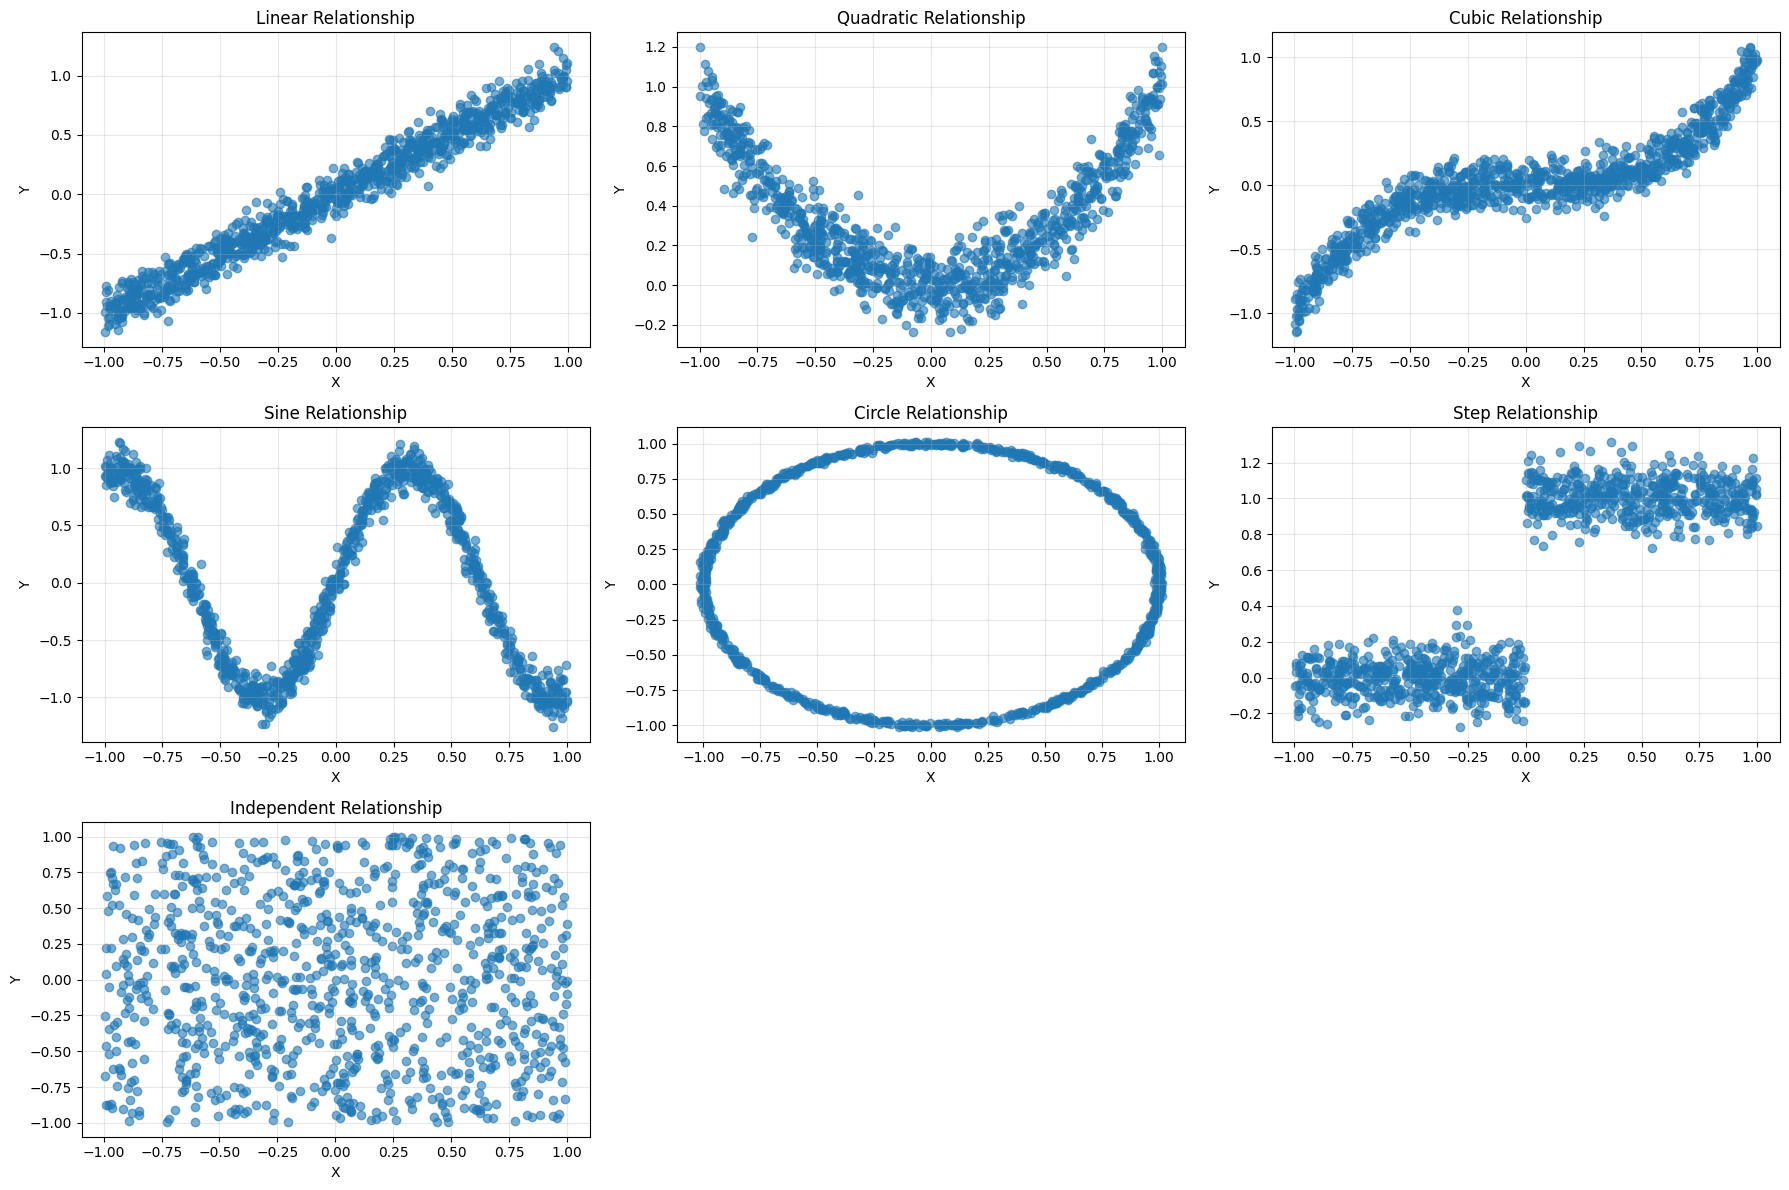

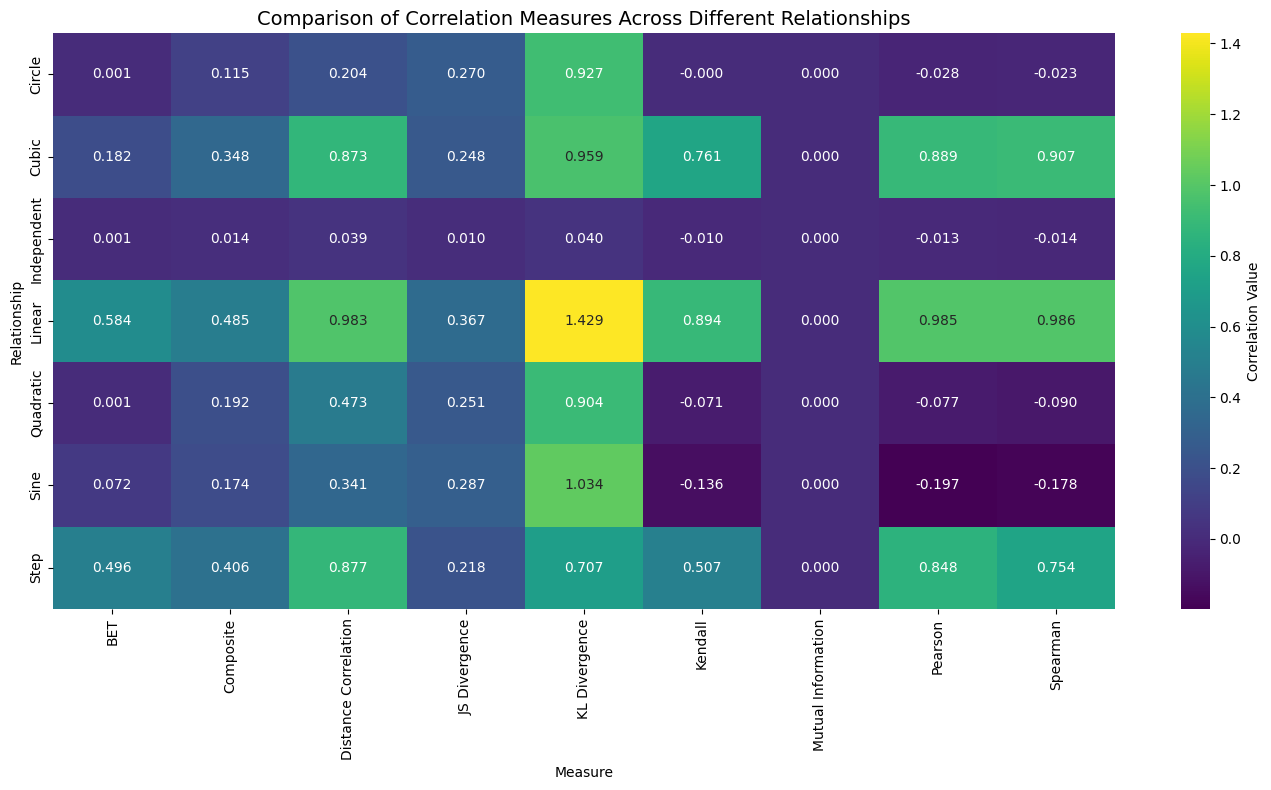

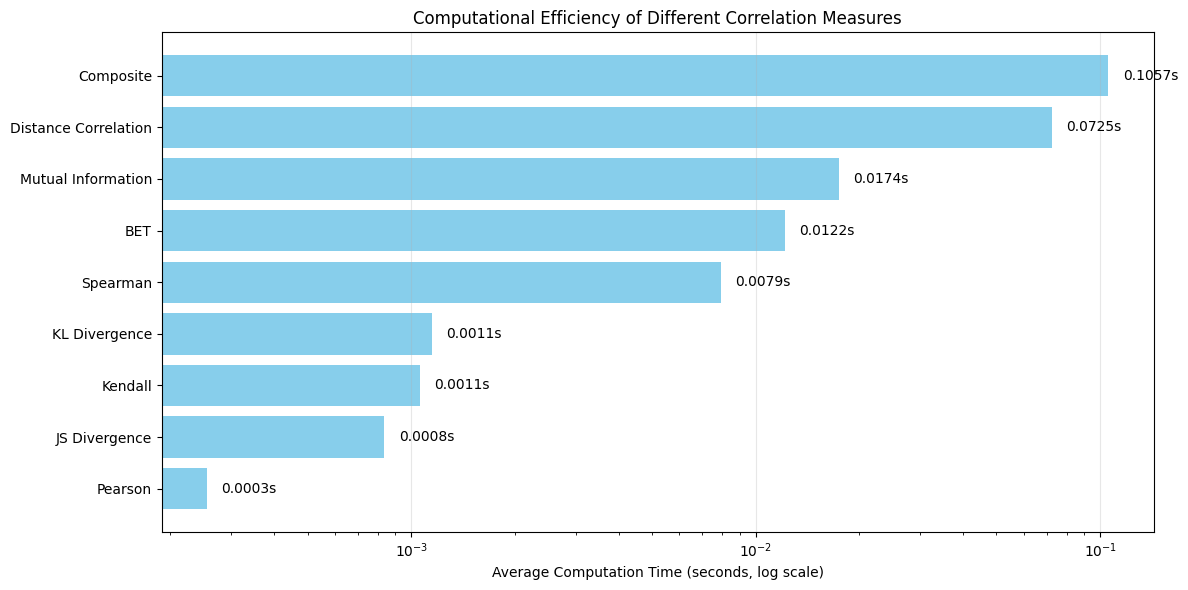

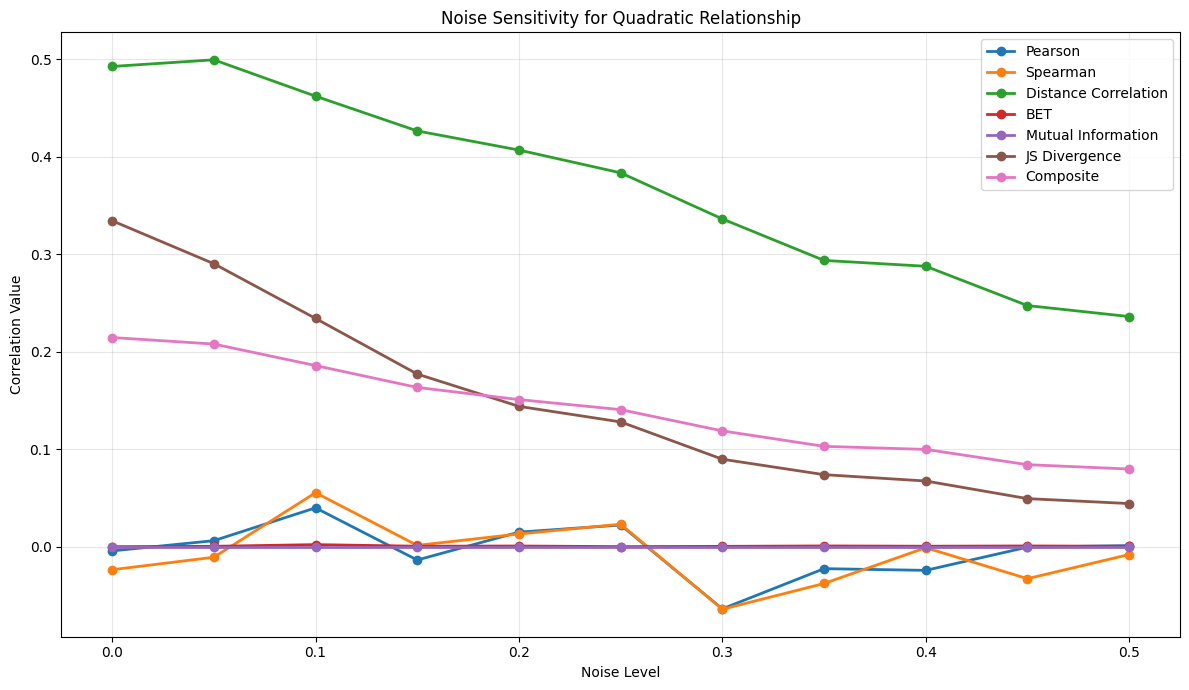

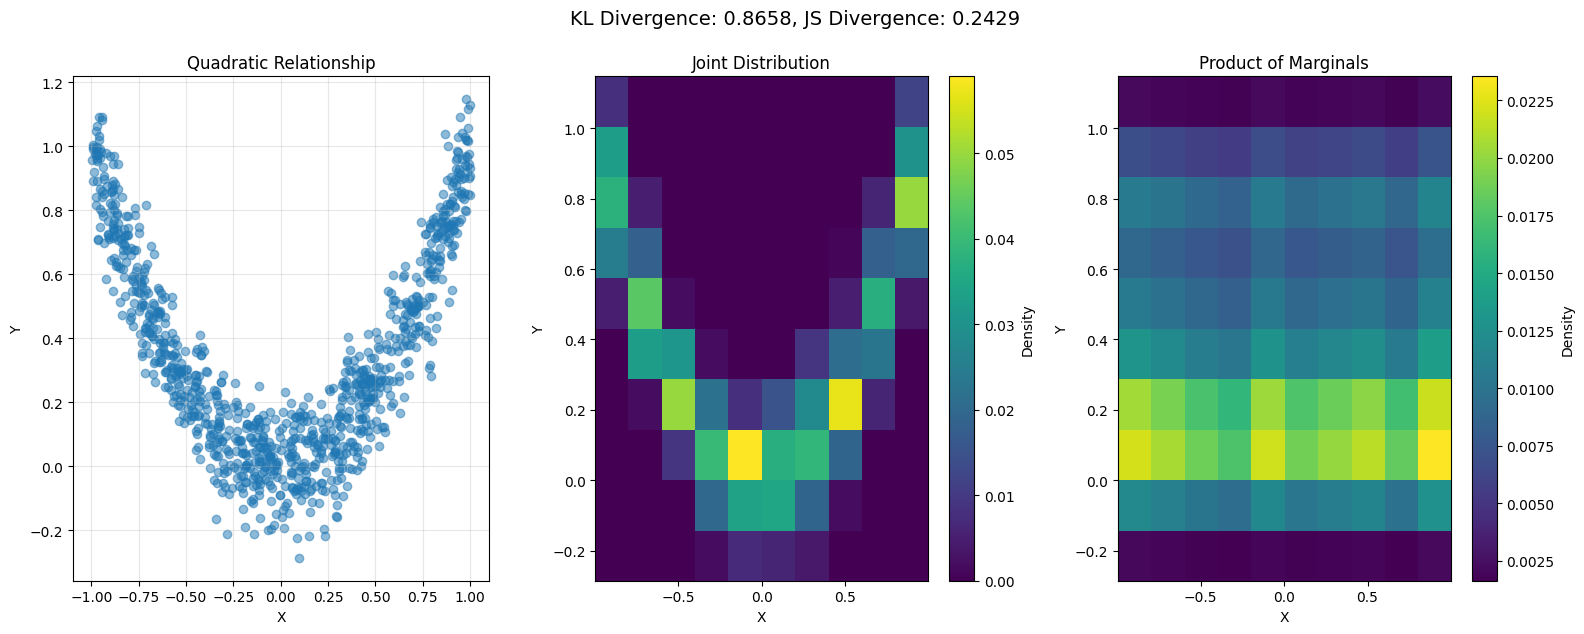

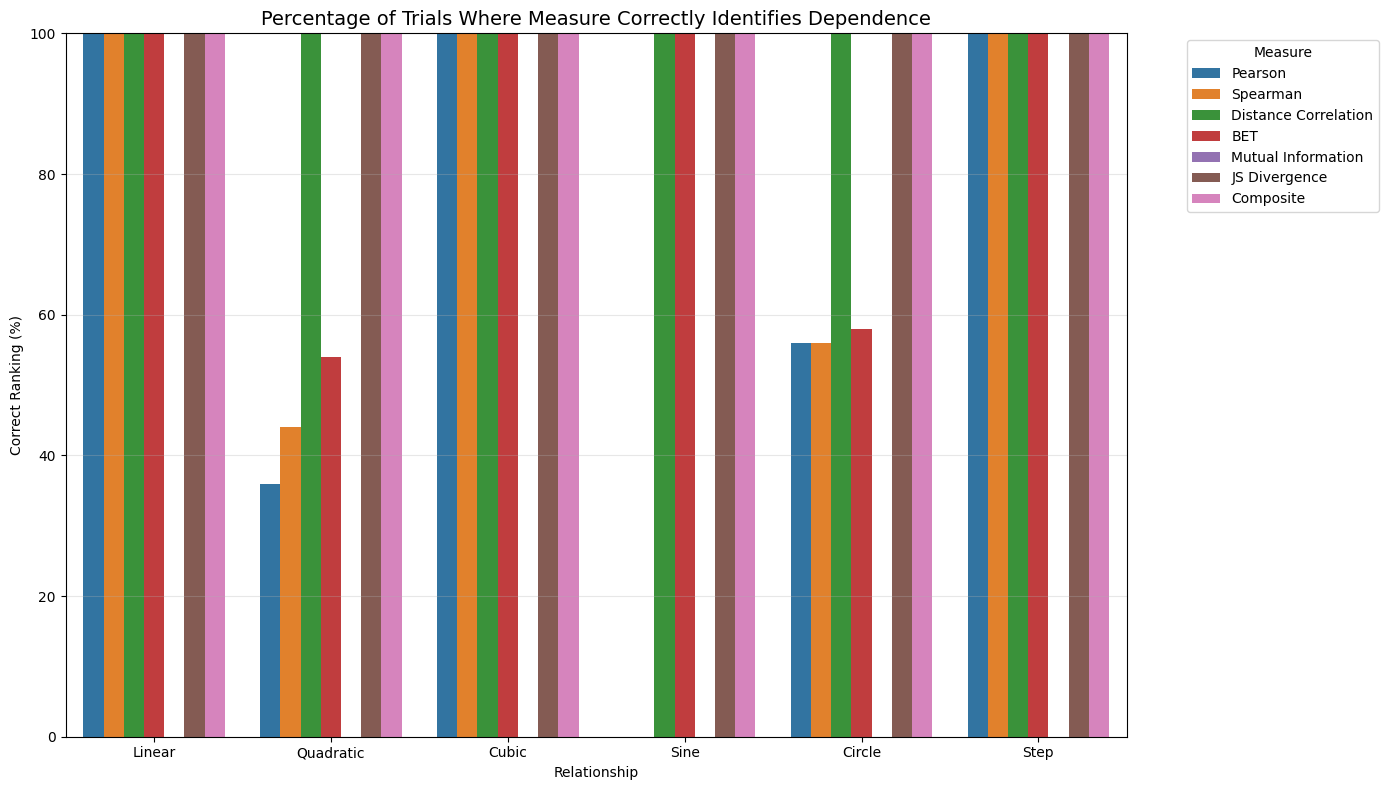

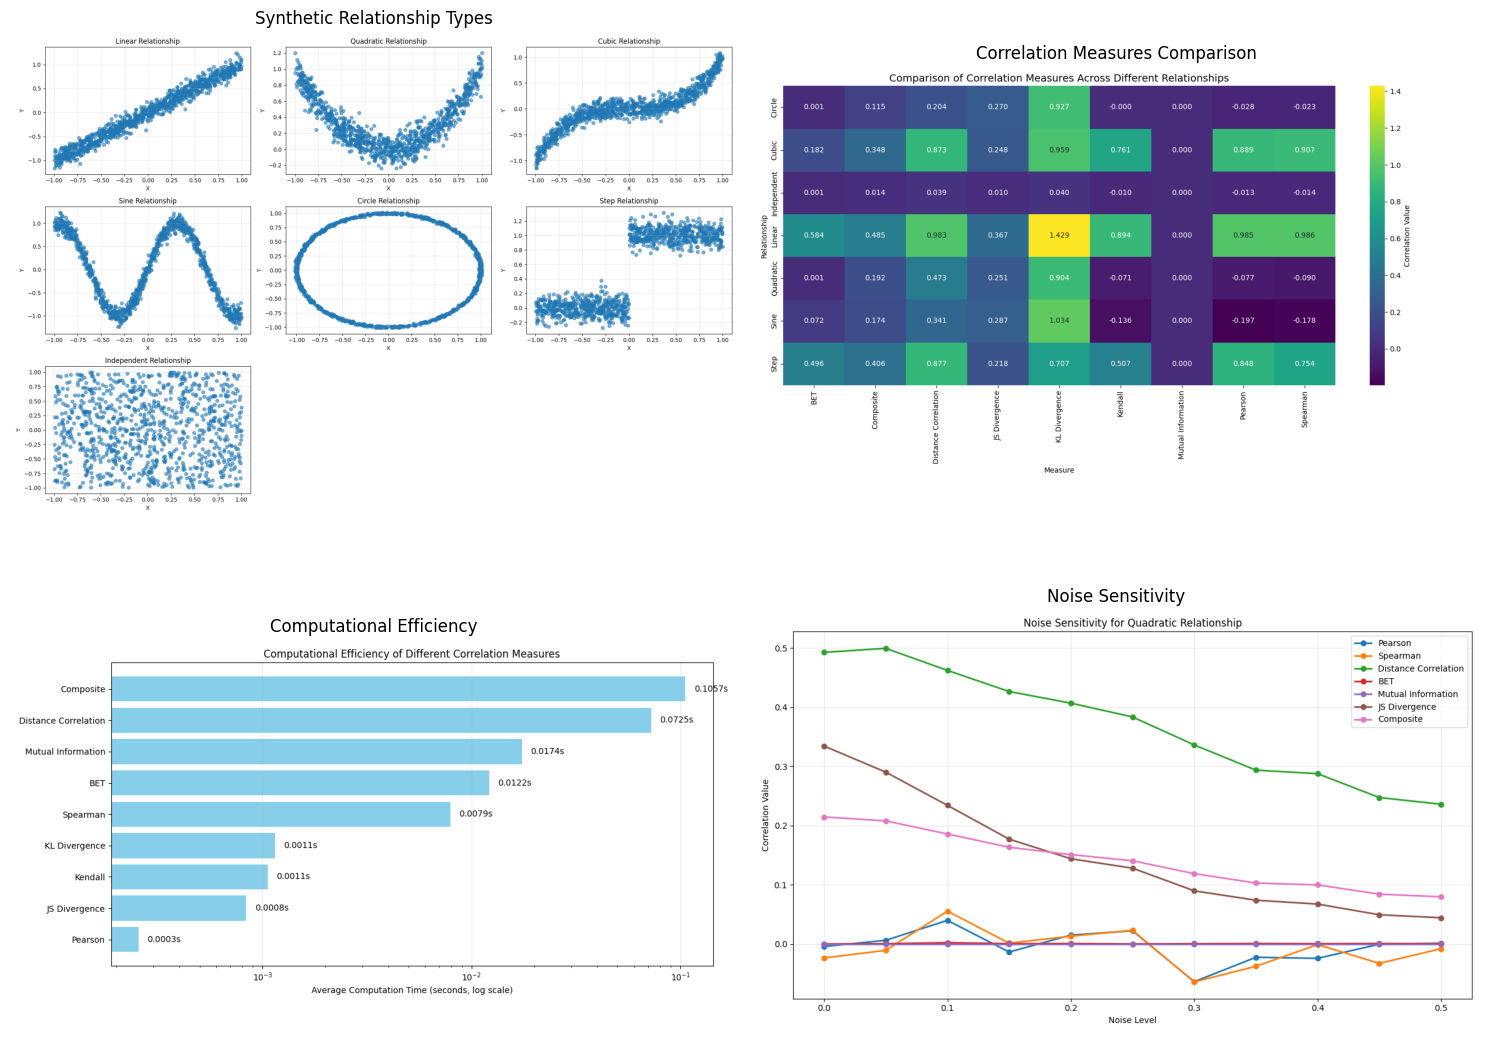


Average correlation value across all relationships:
KL Divergence: 0.8571
Distance Correlation: 0.5413
Pearson: 0.3439
Spearman: 0.3345
Kendall: 0.2777
Composite: 0.2477
JS Divergence: 0.2359
BET: 0.1909
Mutual Information: 0.0000

Average computation time across all relationships:
Pearson: 0.0003 seconds
JS Divergence: 0.0008 seconds
Kendall: 0.0011 seconds
KL Divergence: 0.0011 seconds
Spearman: 0.0079 seconds
BET: 0.0122 seconds
Mutual Information: 0.0174 seconds
Distance Correlation: 0.0725 seconds
Composite: 0.1057 seconds


In [38]:
# Import the module
import correlation_measures
import correlation_comparison
import matplotlib.pyplot as plt

# Run full analysis
results = correlation_comparison.run_full_analysis(n_samples=1000, noise_level=0.1)

# Display plots
plt.figure(figsize=(15, 12))
plt.subplot(221)
results['relationships_plot'].savefig('relationships.png')
plt.imshow(plt.imread('relationships.png'))
plt.axis('off')
plt.title('Synthetic Relationship Types')

plt.subplot(222)
results['heatmap'].savefig('heatmap.png')
plt.imshow(plt.imread('heatmap.png'))
plt.axis('off')
plt.title('Correlation Measures Comparison')

plt.subplot(223)
results['time_plot'].savefig('time_plot.png')
plt.imshow(plt.imread('time_plot.png'))
plt.axis('off')
plt.title('Computational Efficiency')

plt.subplot(224)
results['noise_sensitivity'].savefig('noise_sensitivity.png')
plt.imshow(plt.imread('noise_sensitivity.png'))
plt.axis('off')
plt.title('Noise Sensitivity')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAverage correlation value across all relationships:")
avg_values = results['comparison_df'].groupby('Measure')['Value'].mean().sort_values(ascending=False)
for measure, avg in avg_values.items():
    print(f"{measure}: {avg:.4f}")

print("\nAverage computation time across all relationships:")
avg_times = results['comparison_df'].groupby('Measure')['Time (s)'].mean().sort_values()
for measure, avg in avg_times.items():
    print(f"{measure}: {avg:.4f} seconds")

<Figure size 1800x1500 with 0 Axes>

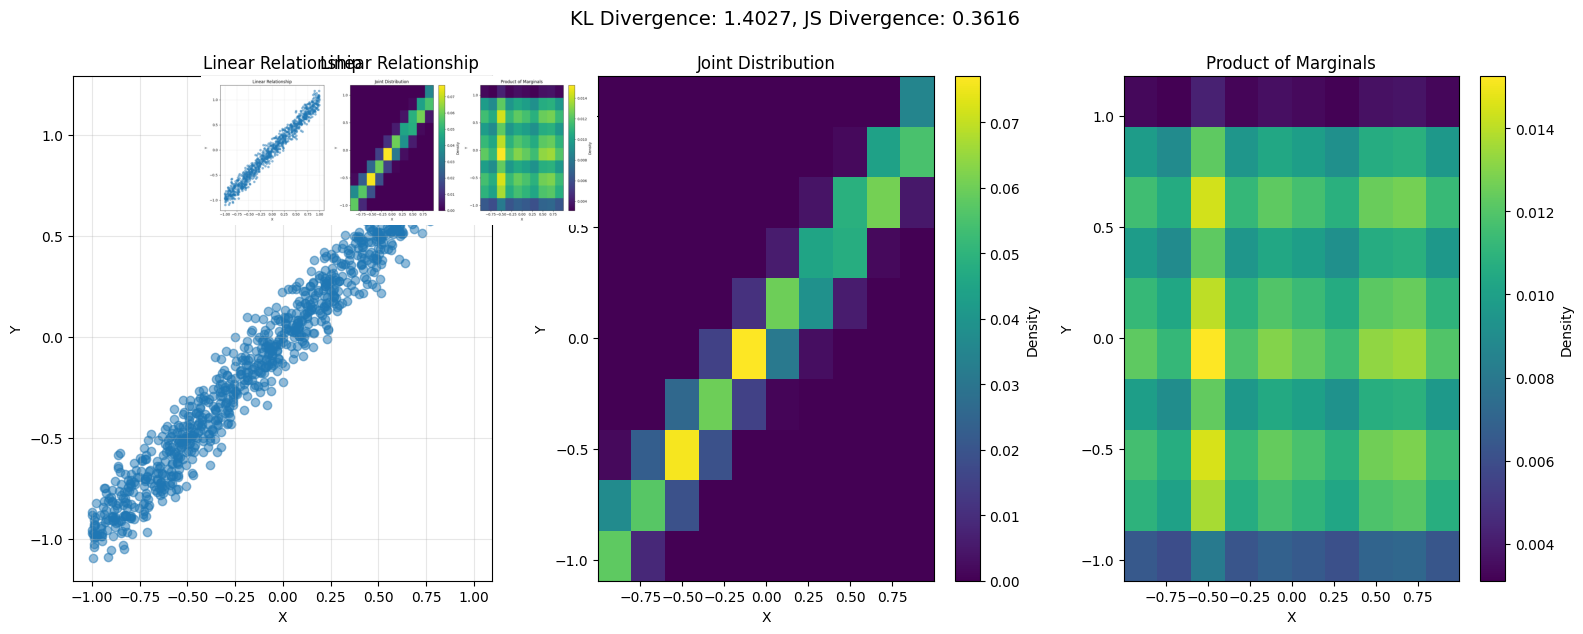

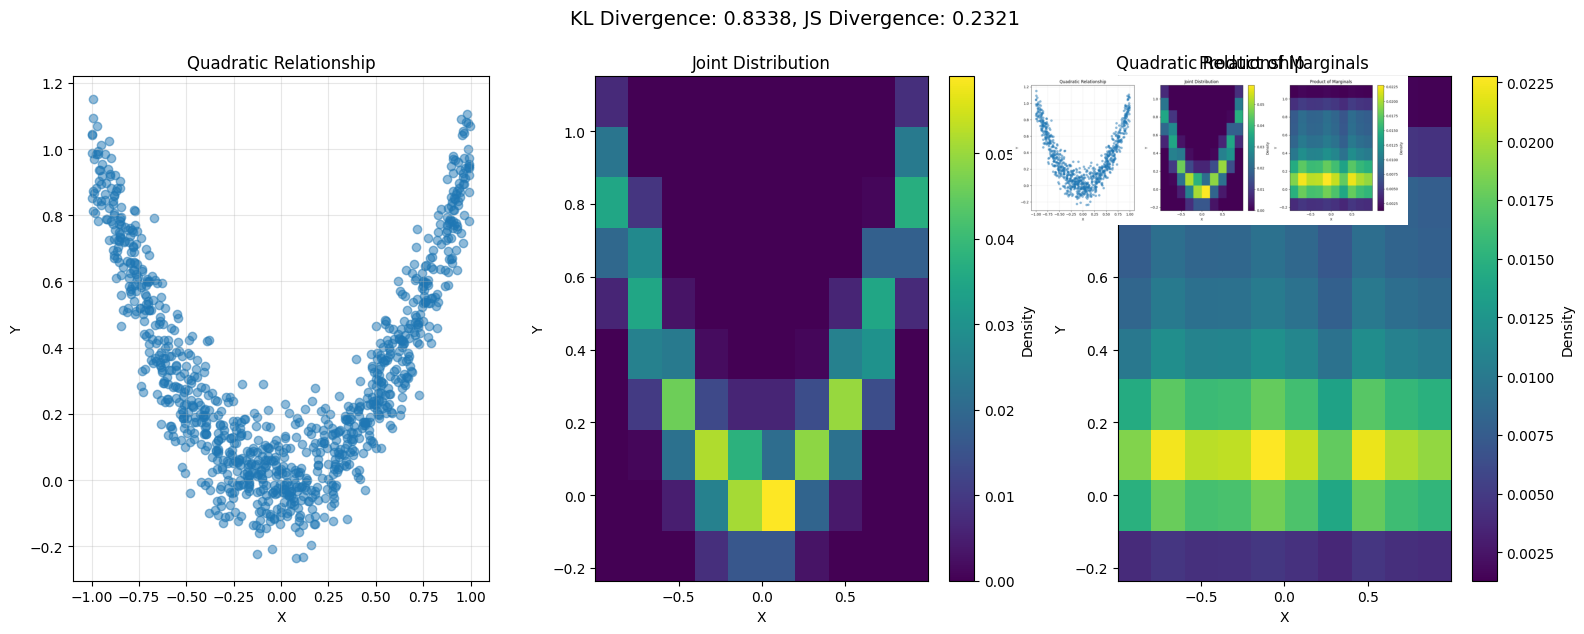

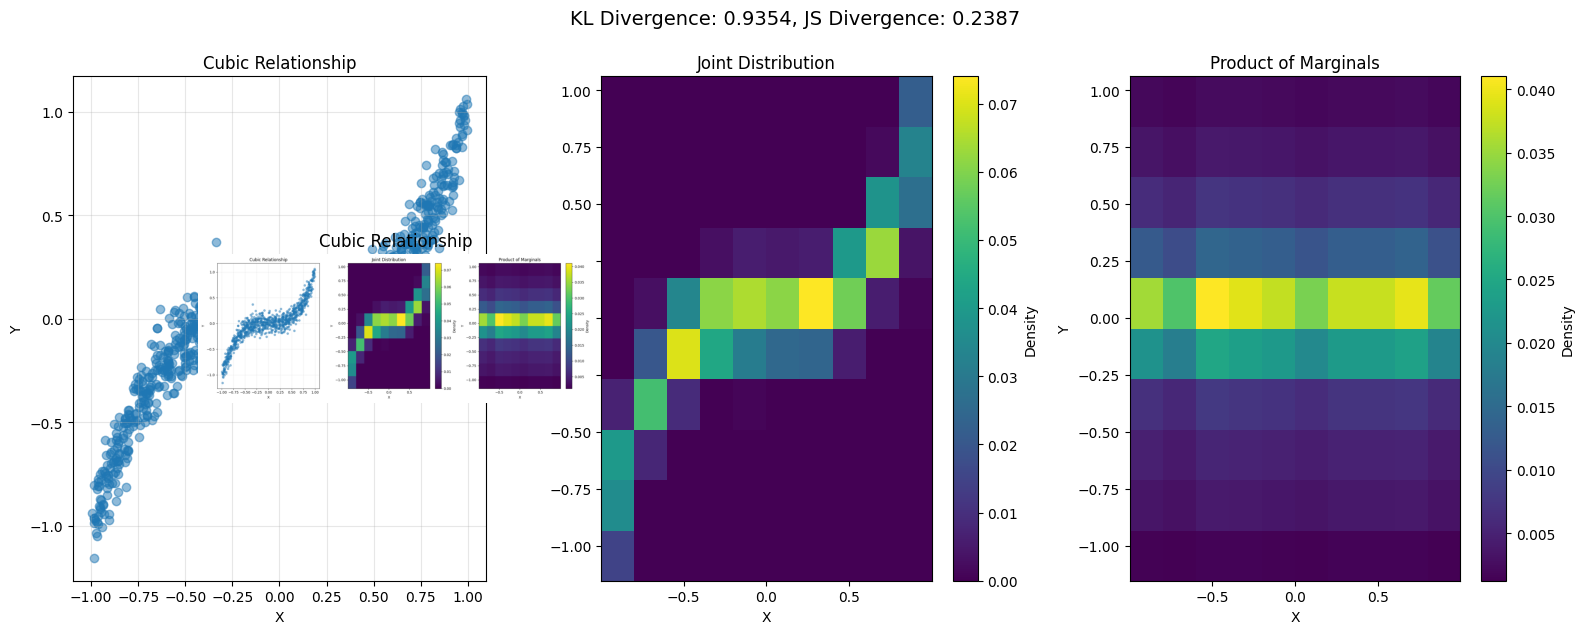

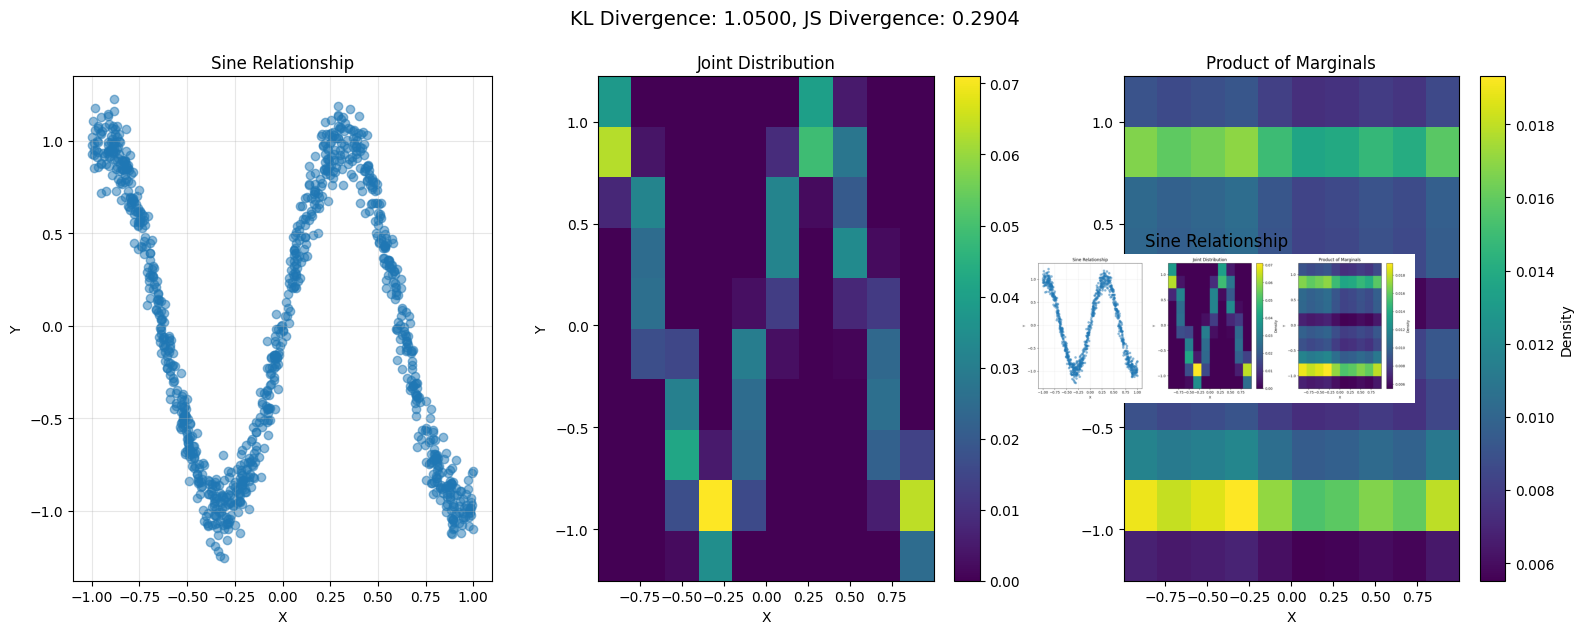

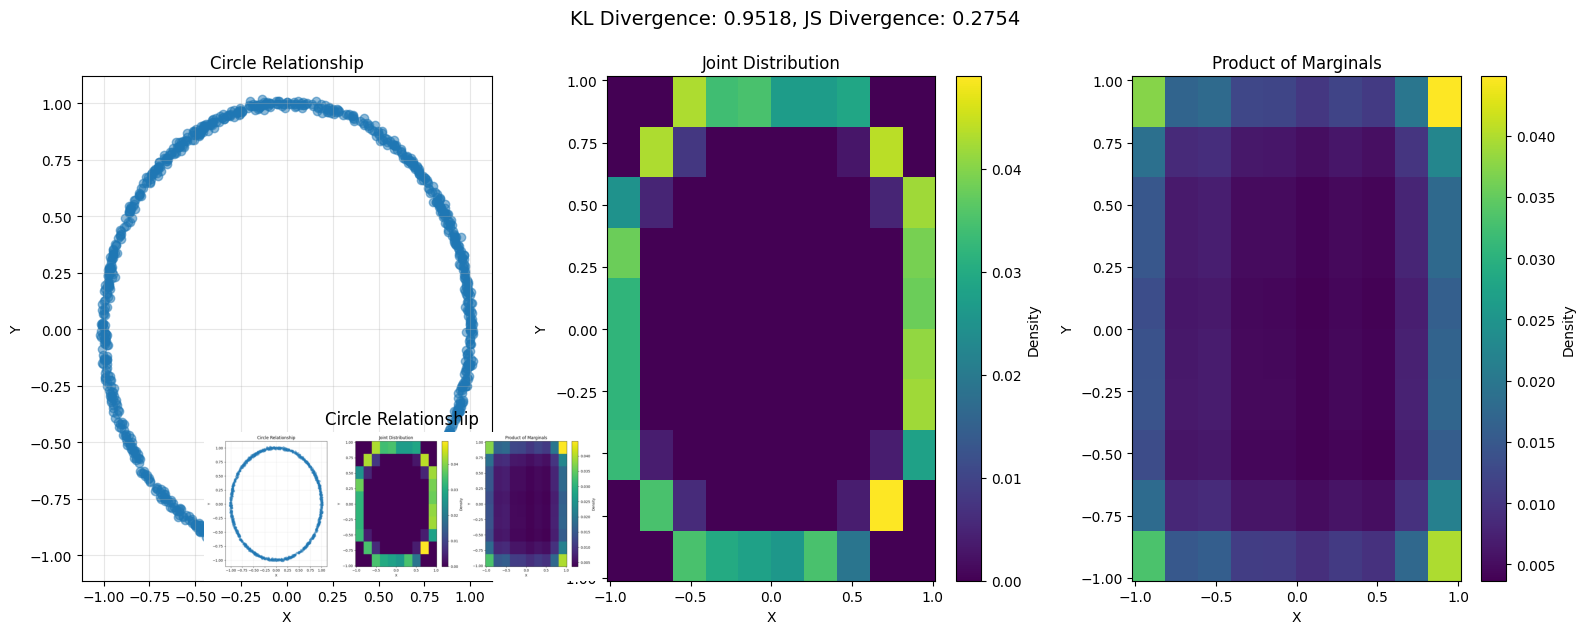

In [39]:
# Visualize distributions for different relationship types
relationship_types = ['linear', 'quadratic', 'cubic', 'sine', 'circle']

plt.figure(figsize=(18, 15))
for i, rel_type in enumerate(relationship_types):
    # Generate the visualization
    dist_vis = correlation_comparison.visualize_distributions(
        relationship_type=rel_type,
        n_samples=1000,
        noise_level=0.1
    )

    # Save and display
    dist_vis.savefig(f'{rel_type}_dist.png')
    plt.subplot(3, 2, i+1)
    plt.imshow(plt.imread(f'{rel_type}_dist.png'))
    plt.axis('off')
    plt.title(f'{rel_type.capitalize()} Relationship')

plt.tight_layout()
plt.show()

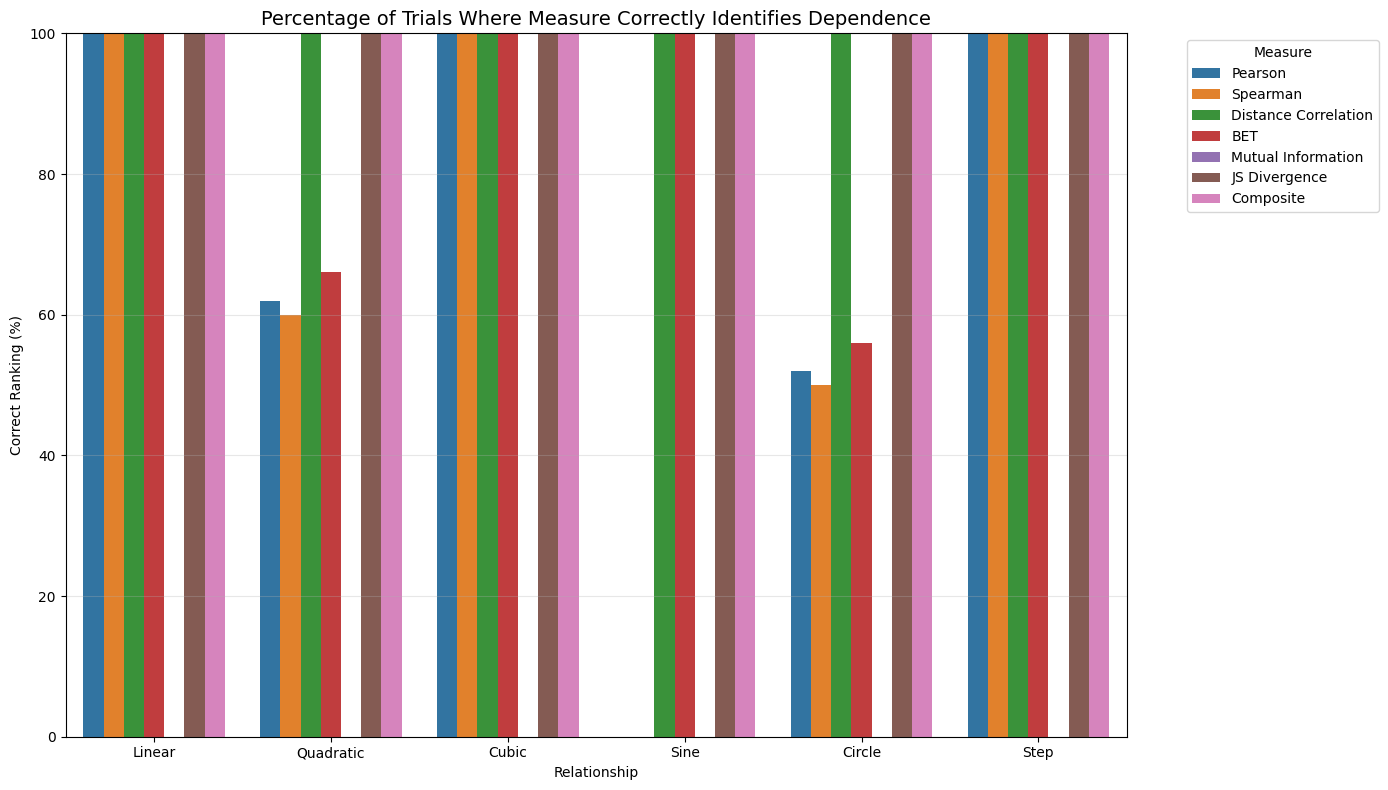

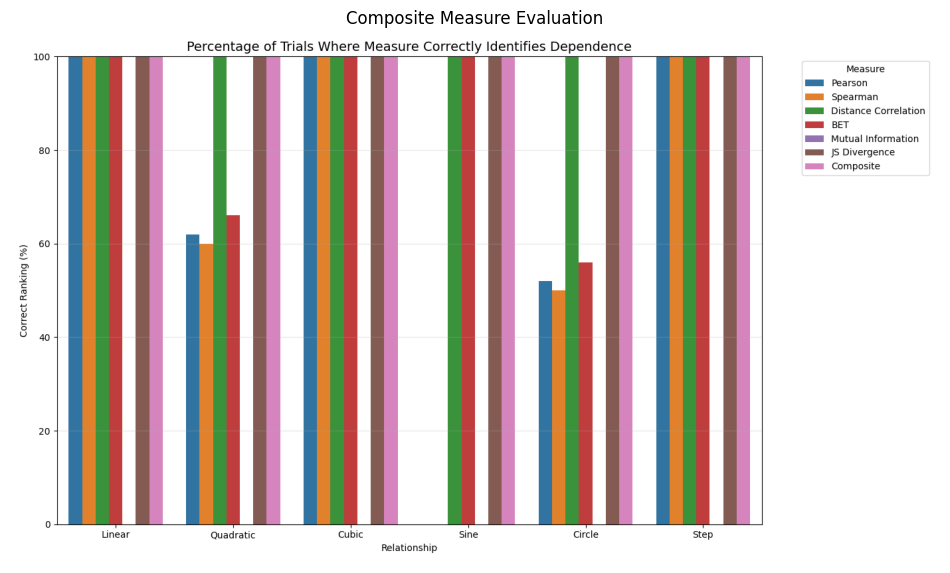


Average correct ranking percentage across all relationships:
Composite: 100.00%
Distance Correlation: 100.00%
JS Divergence: 100.00%
BET: 87.00%
Pearson: 69.00%
Spearman: 68.33%
Mutual Information: 0.00%


In [ ]:
# Evaluate the composite measure
composite_fig, ranking_df = correlation_comparison.evaluate_composite_measure(
    n_trials=50,
    n_samples=1000
)

plt.figure(figsize=(12, 8))
composite_fig.savefig('composite_evaluation.png')
plt.imshow(plt.imread('composite_evaluation.png'))
plt.axis('off')
plt.title('Composite Measure Evaluation')
plt.show()

# Print summary
print("\nAverage correct ranking percentage across all relationships:")
avg_rankings = ranking_df.groupby('Measure')['Correct Ranking (%)'].mean().sort_values(ascending=False)
for measure, avg in avg_rankings.items():
    print(f"{measure}: {avg:.2f}%")

In [28]:
# Test different weights for the composite measure
weight_sets = [
    {'Distance Correlation': 0.4, 'Mutual Information': 0.3, 'BET': 0.2, 'JS Divergence': 0.1},
    {'Distance Correlation': 0.25, 'Mutual Information': 0.25, 'BET': 0.25, 'JS Divergence': 0.25},
    {'Distance Correlation': 0.1, 'Mutual Information': 0.2, 'BET': 0.4, 'JS Divergence': 0.3}
]

# Generate a quadratic relationship
x, y = correlation_measures.generate_data('quadratic', n_samples=1000, noise_level=0.2)

# Test each weight set
for i, weights in enumerate(weight_sets):
    score = correlation_measures.composite_measure(x, y, weights)
    print(f"Weight set {i+1}: {weights}")
    print(f"Composite score: {score:.4f}\n")

Weight set 1: {'Distance Correlation': 0.4, 'Mutual Information': 0.3, 'BET': 0.2, 'JS Divergence': 0.1}
Composite score: 0.1823

Weight set 2: {'Distance Correlation': 0.25, 'Mutual Information': 0.25, 'BET': 0.25, 'JS Divergence': 0.25}
Composite score: 0.1418

Weight set 3: {'Distance Correlation': 0.1, 'Mutual Information': 0.2, 'BET': 0.4, 'JS Divergence': 0.3}
Composite score: 0.0868



In [29]:
# Compare measures with different noise levels
for noise in [0.0, 0.1, 0.3, 0.5]:
    print(f"\nNoise level: {noise}")
    x, y = correlation_measures.generate_data('sine', n_samples=1000, noise_level=noise)
    results = correlation_measures.evaluate_all_measures(x, y)

    for measure, (value, time_taken) in results.items():
        print(f"{measure}: {value:.4f}")

    # Add composite measure
    comp_value = correlation_measures.composite_measure(x, y)
    print(f"Composite: {comp_value:.4f}")


Noise level: 0.0
Pearson: -0.1898
Spearman: -0.1962
Kendall: -0.1675
Distance Correlation: 0.3389
BET: 0.1018
Mutual Information: 0.0000
KL Divergence: 1.1643
JS Divergence: 0.3202
Composite: 0.1861

Noise level: 0.1
Pearson: -0.2451
Spearman: -0.2436
Kendall: -0.1818
Distance Correlation: 0.3553
BET: 0.0724
Mutual Information: 0.0000
KL Divergence: 1.0647
JS Divergence: 0.2951
Composite: 0.1801

Noise level: 0.3
Pearson: -0.2051
Spearman: -0.1889
Kendall: -0.1349
Distance Correlation: 0.3247
BET: 0.0190
Mutual Information: 0.0000
KL Divergence: 0.7407
JS Divergence: 0.2111
Composite: 0.1434

Noise level: 0.5
Pearson: -0.2089
Spearman: -0.2107
Kendall: -0.1539
Distance Correlation: 0.3048
BET: 0.0279
Mutual Information: 0.0000
KL Divergence: 0.5180
JS Divergence: 0.1496
Composite: 0.1269


## testing
